# CD4+ T cell behavior in COVID-19 infection


In [1]:
# Load library and BoolNetPerturb functions
library(dplyr)
library(BoolNet)
library(alluvial)

source( 'BooleanHelper.r' )
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }
# Load data
net <-  loadNetwork("data/thsocs_net.csv")
enviro <- read.csv("data/thsocs_environment.csv")
labels <- read.csv("data/thsocs_label.csv")

net.socs <- c('SOCS1', 'SOCS2', 'SOCS3', 'SOCS5')
net.ext  <- c('IFNGe', 'IL12e', 'IL2e', 'IL4e', 'IL6e', 'TGFBe', 'IL10e', 'TCR')

env.cov <- c('covmild', 'covmod', 'covsev', 'covtgfb', 'covil10')

net.cov <- list()
for (env in env.cov) {
    net.cov[env] <- list(fixGenes(net, colnames(enviro), enviro[env,]))
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## CD4+ T cell regulatory network and subsets

### Regulatory network

In [2]:
print(c('# nodes :', length(net$genes)))
net.topo <- getNetTopology(net)
writexl::write_xlsx(net.topo,'results/thsocs_net_topology.xlsx')
print(c('# edges :', length(net.topo[[1]]) - sum(sapply(net$genes, isGeneInput, net=net))  ))

[1] "# nodes :" "21"       
[1] "# edges :" "81"       


### Attractors


[1] Tr    Tex   Th2R  Th1R  Th17  Treg  Th2   Th1   Naive
Levels: Naive Tex Th1 Th17 Th1R Th2 Th2R Tr Treg

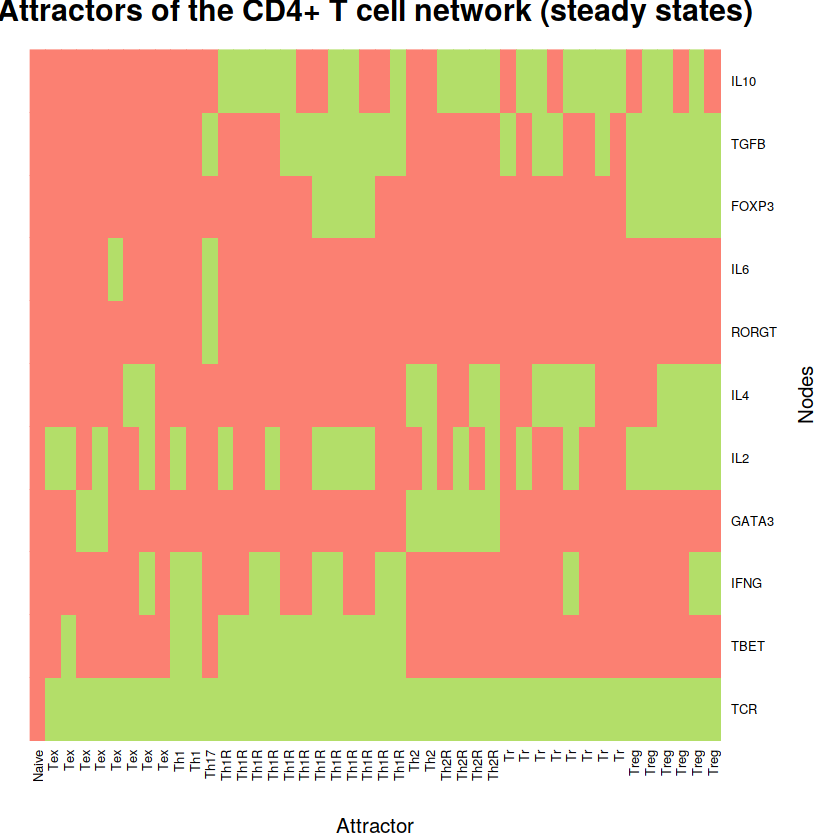

In [3]:
attr.table <- get.attr.table(net, labels, simplify=T, method="sat.exhaustive",
                             file.name='results/thsocs_attr_table.csv' )
#tail(attr.table,10)
unique(attr.table$label)

selected.nodes <- c("TCR", "TBET","IFNG","GATA3","IL2","IL4","RORGT","IL6","FOXP3","TGFB","IL10")
file.name <- NULL
#file.name <- "images/thsocs_attr_table.pdf"
plot.attr.table(attr.table, file.name=file.name,
                title='Attractors of the CD4+ T cell network', selected.nodes=selected.nodes)

## Basin size by environment

In [4]:
# plot environments
enviro

,IFNGe,IL12e,IL2e,IL4e,IL6e,TGFBe,IL10e,TCR
Basal,0,0,0,0,0,0,0,0
pro-Th1,1,1,0,0,0,0,0,1
pro-Th2,0,0,1,1,0,0,0,1
pro-Th17,0,0,0,0,1,1,0,1
pro-Treg,0,0,1,0,0,1,0,1
pro-Tr,0,0,0,0,0,1,1,1
covmild,0,1,1,0,0,0,0,1
covmod,1,1,0,0,0,0,0,1
covsev,1,1,0,1,1,0,0,1
covtgfb,1,1,0,1,1,1,0,1


In [5]:
file.env.attr <- "results/thsocs_env_attr.csv"
file.env.attr.fig <- "images/thsocs_env_attr.pdf"


env.attr <- perturbNetworkFixedNodes(net, label.rules=labels, returnDataFrame='basinSize',
                                     genes  = rep( list(colnames(enviro)), times=nrow(enviro) ),
                                     values = lapply( split(enviro,seq_along(enviro[,1])), as.list),
                                     names  = rownames(enviro))
write.csv(env.attr,file.env.attr)
env.attr <- env.attr[row.names(env.attr) != "Naive", , drop = FALSE]
env.attr[] <- lapply( env.attr[], function(x) x/sum(x) )
env.attr['Th1/Th1R',] <- env.attr['Th1',]/env.attr['Th1R',]
env.attr * 100

,Basal,pro-Th1,pro-Th2,pro-Th17,pro-Treg,pro-Tr,covmild,covmod,covsev,covtgfb,covil10
Tex,NaN,7.5195312,4.8095703,0.000000,0.0000000,0.00000,38.7817383,7.5195312,32.1289062,0.00000,0.000000
Th1,NaN,38.3300781,1.6601562,0.000000,0.0000000,0.00000,22.6440430,38.3300781,24.0234375,0.00000,0.000000
Th17,NaN,0.0000000,0.0000000,53.125000,0.9521484,0.00000,0.0000000,0.0000000,0.0000000,21.09375,0.000000
Th1R,NaN,48.7792969,1.6113281,6.640625,16.3085938,16.30859,26.2695312,48.7792969,38.9648438,62.98828,63.867188
Th2,NaN,0.0000000,54.9560547,0.000000,0.0000000,0.00000,0.0000000,0.0000000,0.0000000,0.00000,0.000000
Th2R,NaN,0.5371094,0.6835938,0.000000,0.0000000,0.00000,0.6835938,0.5371094,0.4882812,0.00000,1.171875
Tr,NaN,4.8339844,7.2753906,40.234375,12.8784180,83.69141,2.9663086,4.8339844,4.3945312,15.91797,34.960938
Treg,NaN,0.0000000,29.0039062,0.000000,69.8608398,0.00000,8.6547852,0.0000000,0.0000000,0.00000,0.000000
Th1/Th1R,NaN,78.5785786,103.0303030,0.000000,0.0000000,0.00000,86.1988848,78.5785786,61.6541353,0.00000,0.000000


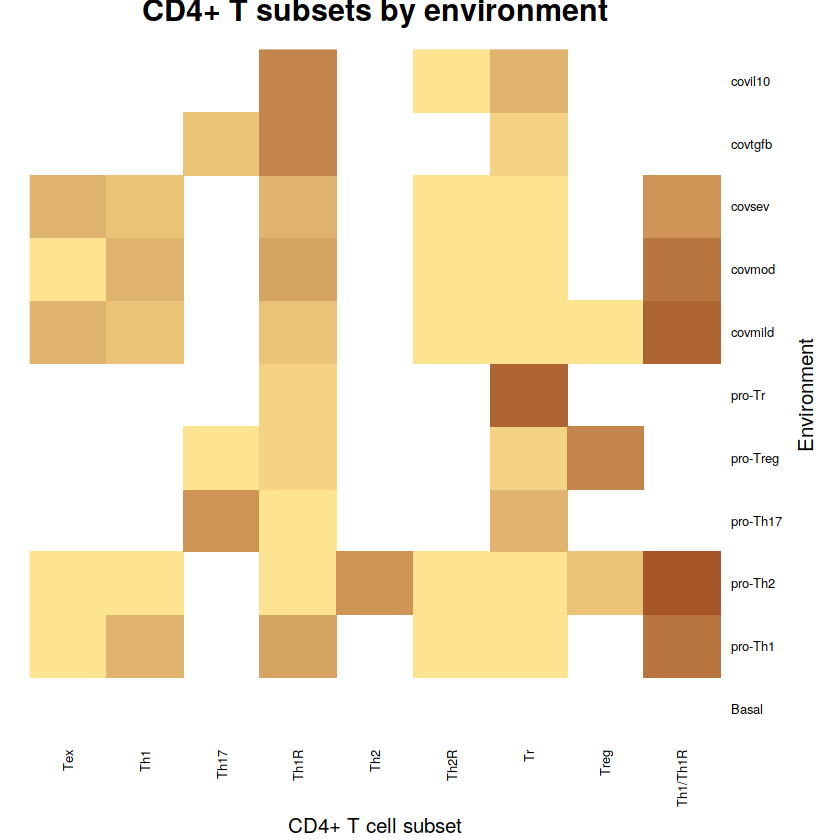

In [6]:
                     
#pdf(file.env.attr.fig)
env.attr[env.attr == 0] <- NA
colfunc <- colorRampPalette(c('#fee391', '#a65628'))
color <- colfunc(10)
heatmap(t(as.matrix( subset(env.attr ))),
        main="CD4+ T subsets by environment", 
        xlab="CD4+ T cell subset", ylab="Environment",
        col=color, cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
#dev.off()

## Transient perturbations

In [7]:
cfm.cov <- list()
for (env in env.cov) {
    file.name <- NULL
    file.name <- paste(c("results/thsocs_cfm_",env,".csv"), collapse='')
    print(file.name)
    cfm <- f.cfm.table(net.cov[[env]], labels, file.name)
    cfm.cov[env] <- list(cfm)
}

[1] "results/thsocs_cfm_covmild.csv"
[1] "results/thsocs_cfm_covmod.csv"
[1] "results/thsocs_cfm_covsev.csv"
[1] "results/thsocs_cfm_covtgfb.csv"
[1] "results/thsocs_cfm_covil10.csv"


### Stability by celltype

[1] "covmild"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


[1] "covmod"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


[1] "covsev"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


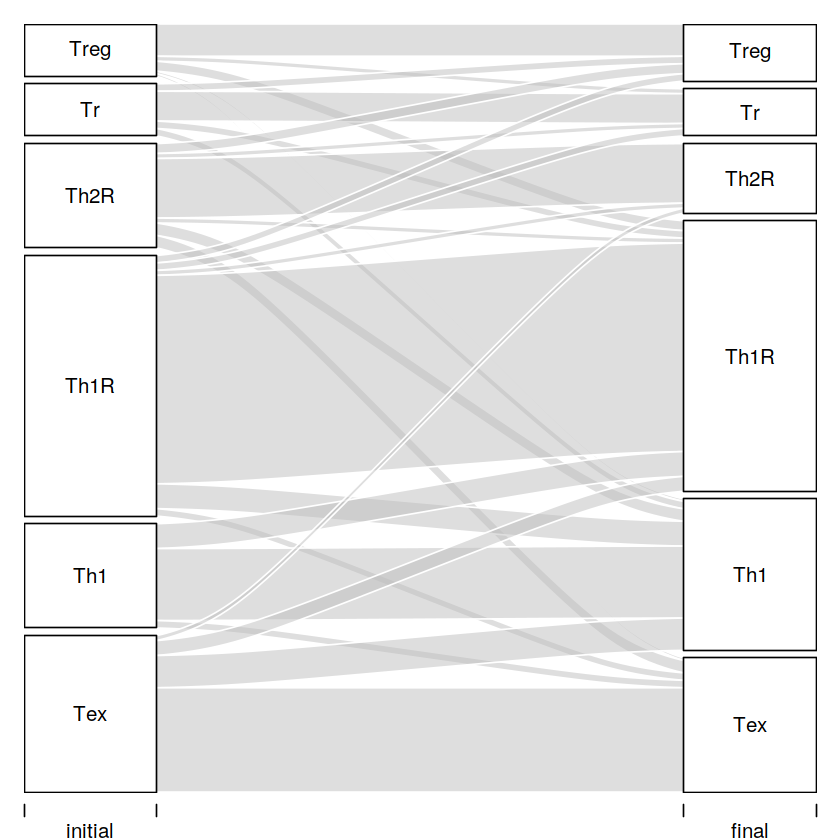

[1] "covtgfb"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


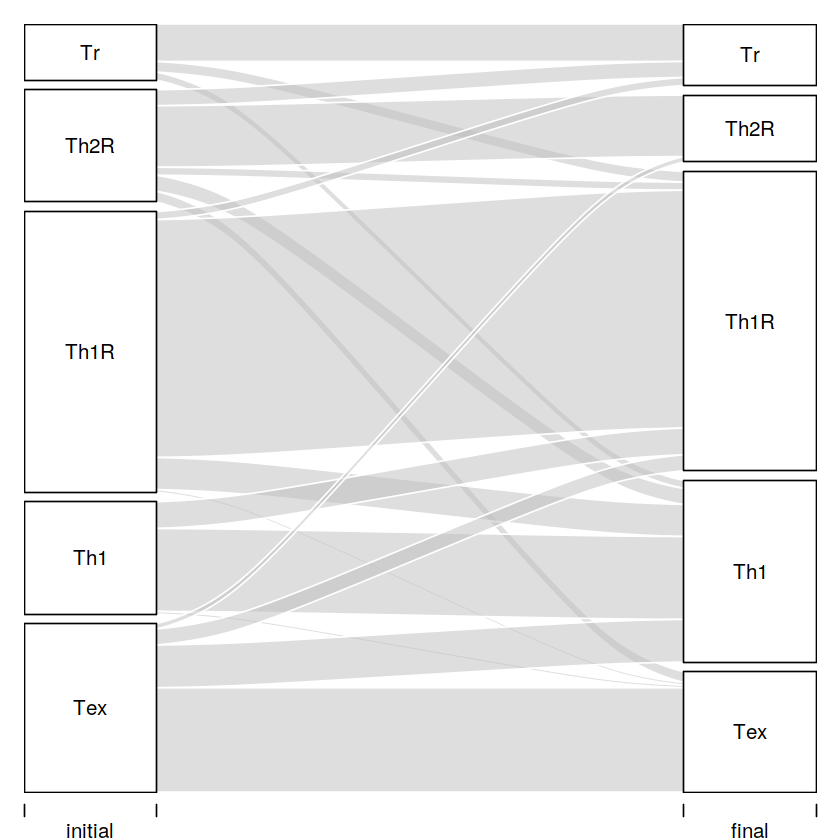

[1] "covil10"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


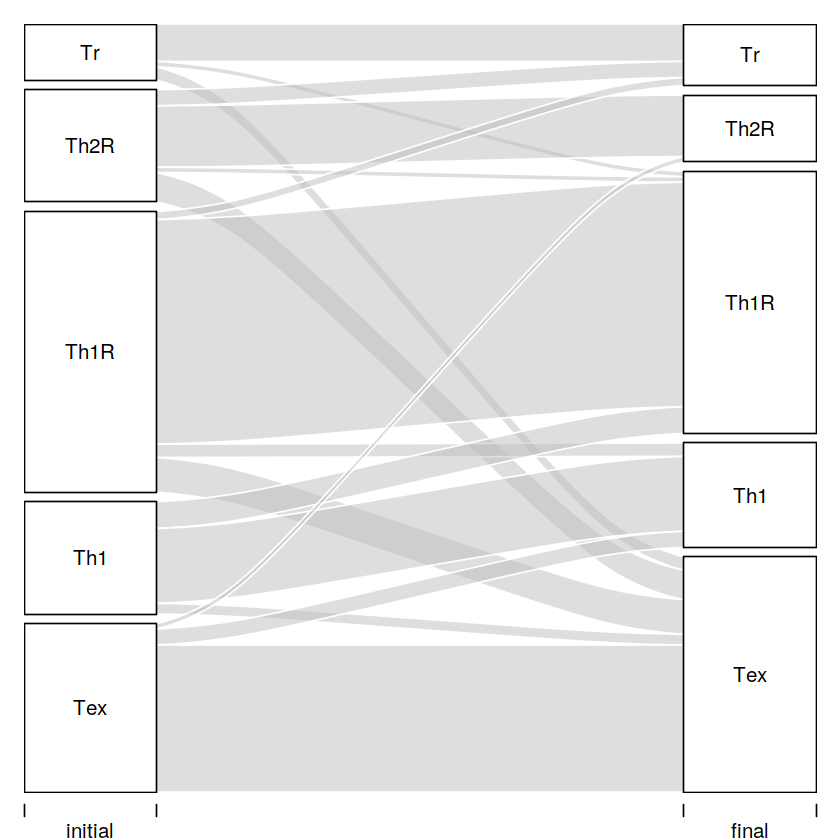

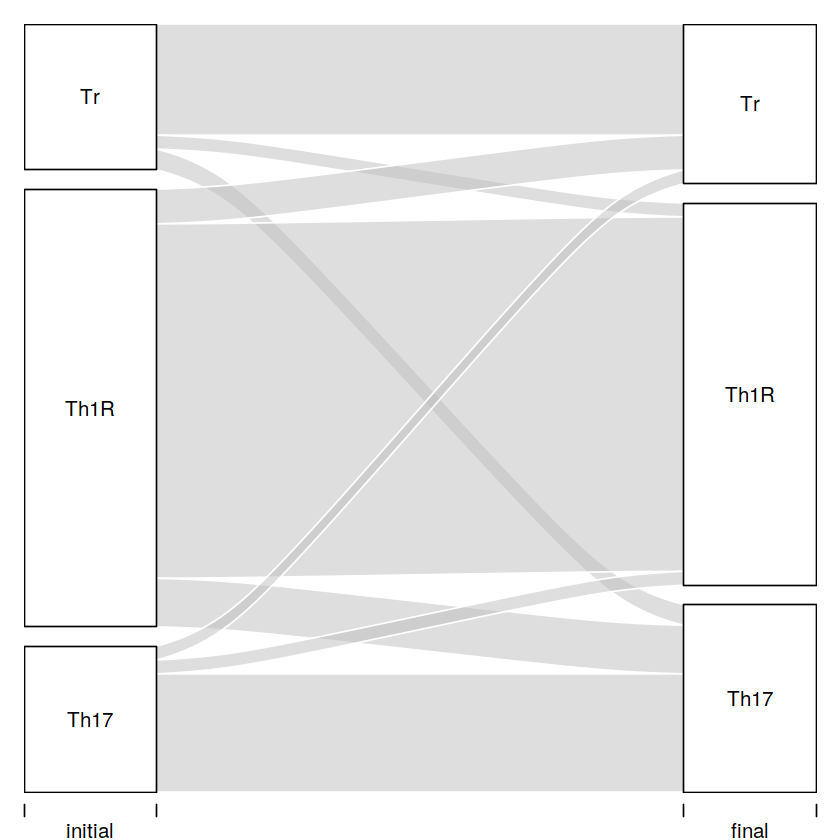

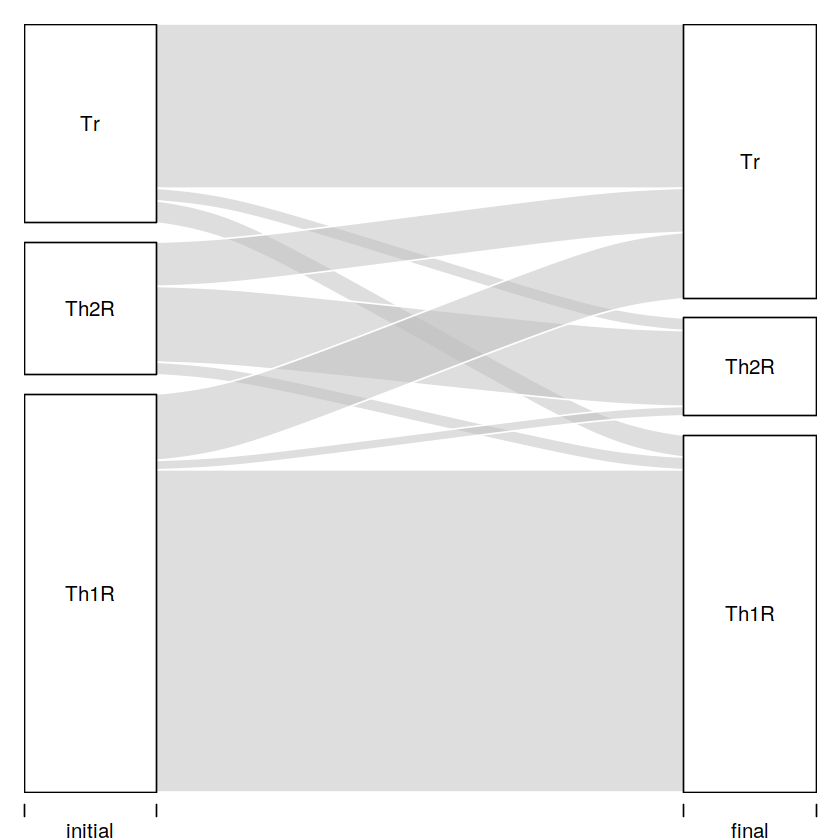

In [8]:
for (env in env.cov) {
    print(env)
    file.name <- NULL
    #file.name <- paste(c("images/thsocs_cfm_alluvial_",env,".pdf"), collapse='')
    title <- paste(c("Transitions between cell types in ",env, "\n with perturbations of time 1"), collapse='')
    plot.cfm.alluvial(cfm.cov[[env]], file.name, title)
}

### Transitions by node

[1] "covmild"
[1] "covmod"


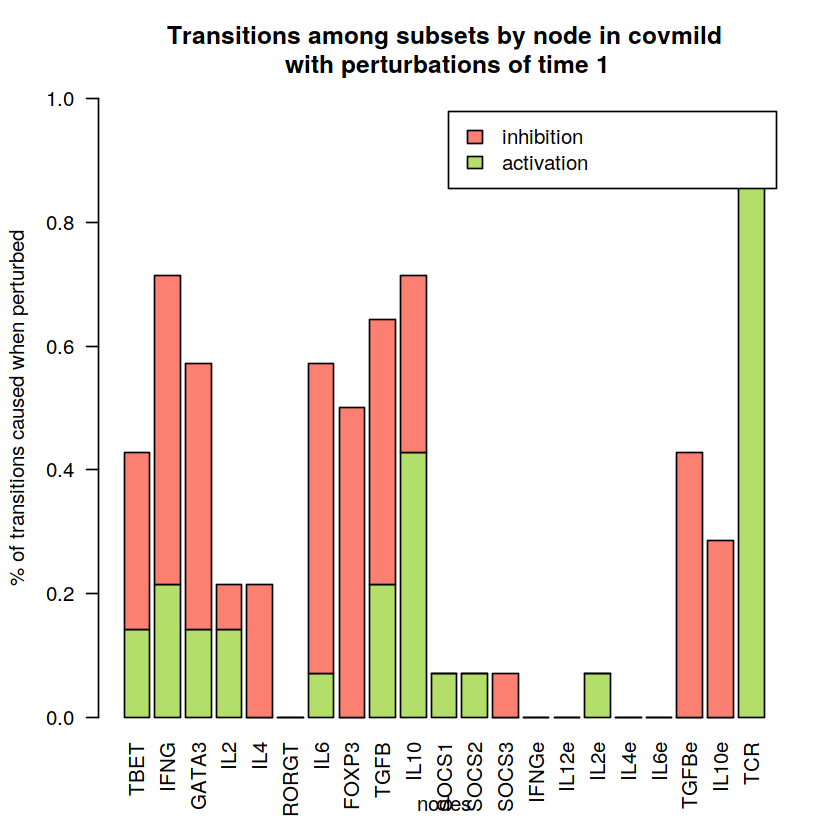

[1] "covsev"


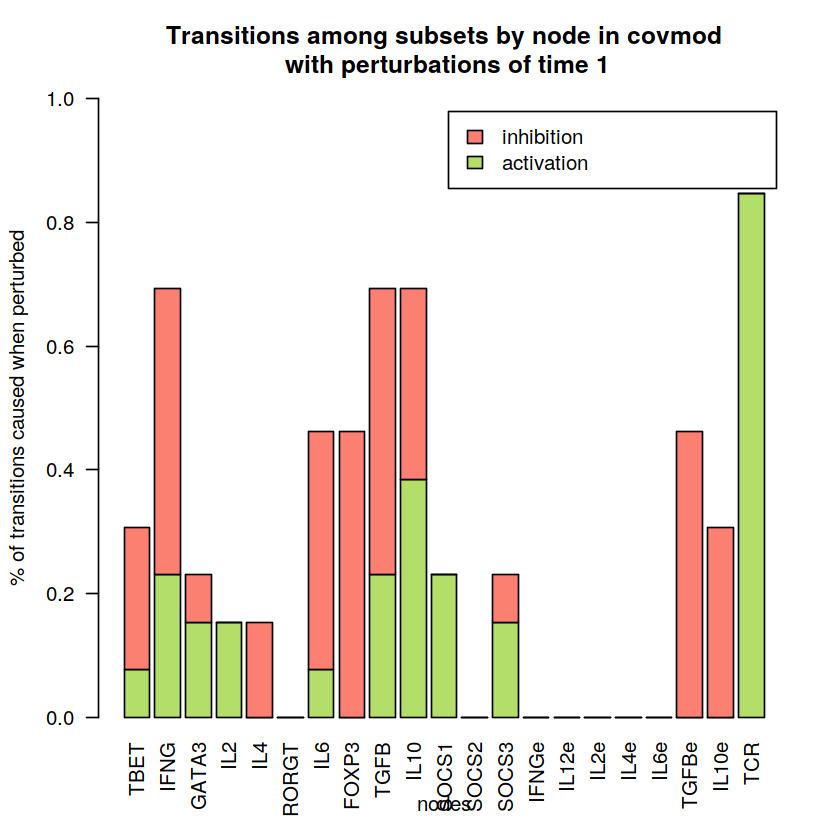

[1] "covtgfb"


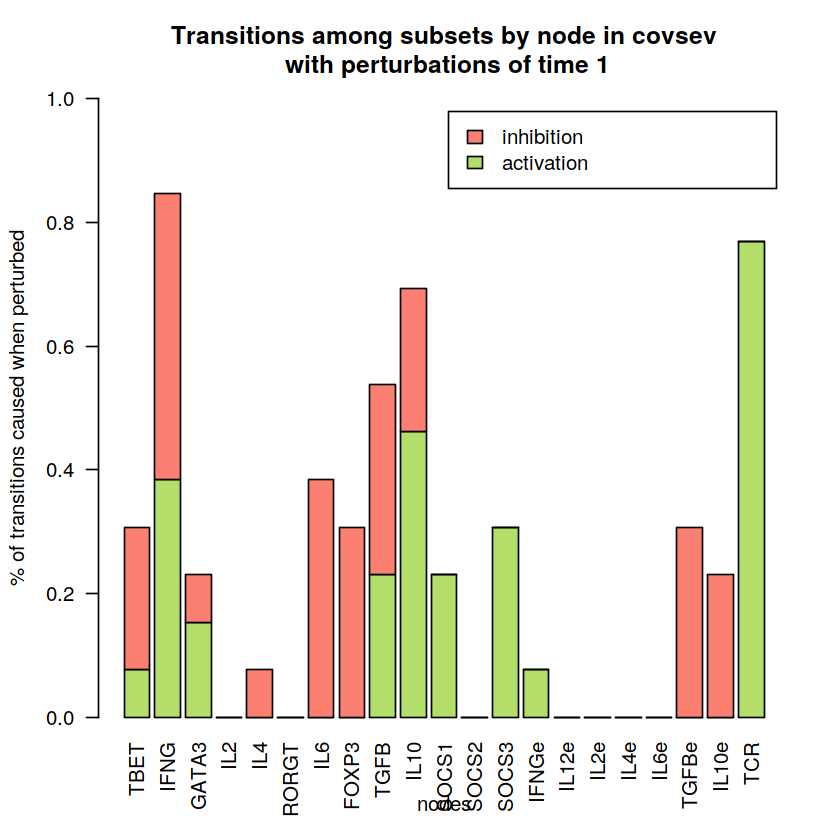

[1] "covil10"


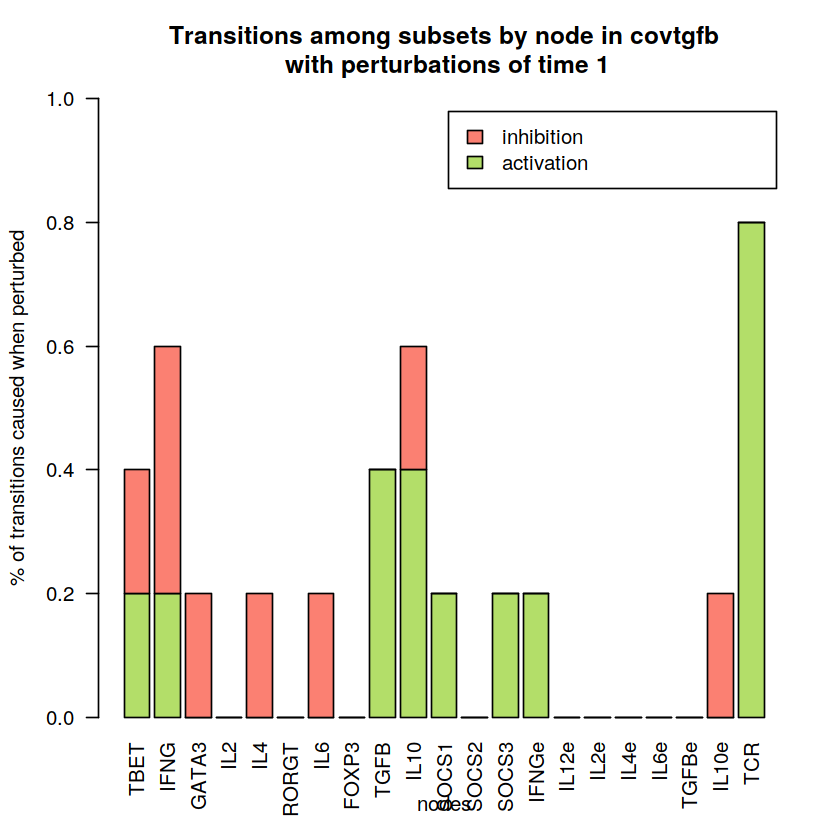

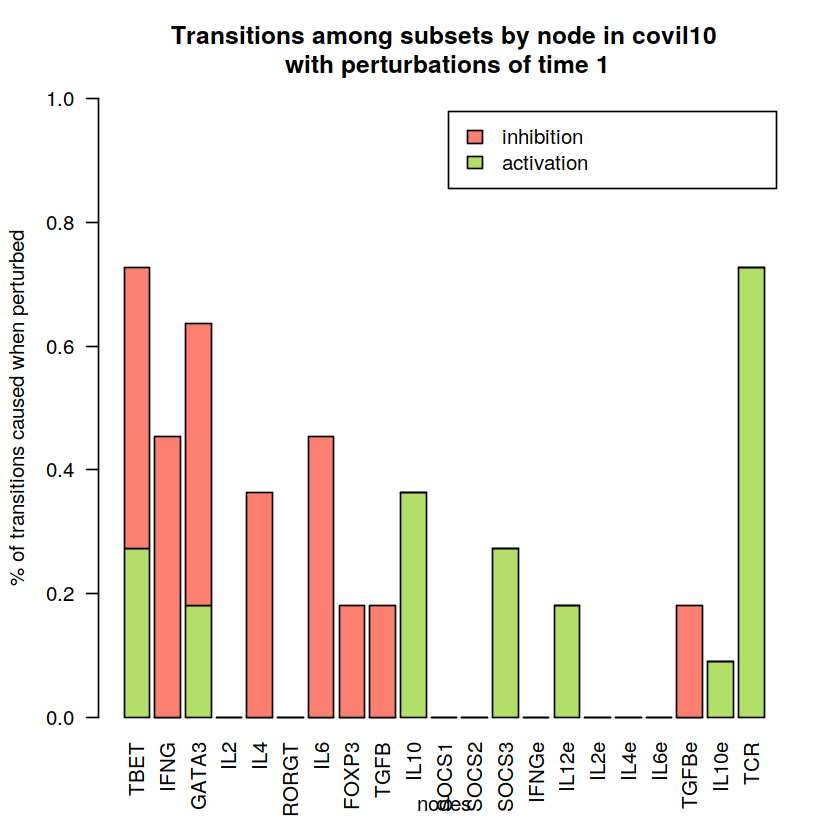

In [9]:
for (env in env.cov) {
    print(env)
    file.name <- NULL
    #file.name <- paste(c("images/thsocs_cfm_trannode_",env,".pdf"), collapse='')
    title <- paste(c("Transitions among subsets by node in ",env, "\n with perturbations of time 1"), collapse='')
    plot.node.transitions(cfm.cov[[env]], file.name, title)
}

## Fixed perturbations

In [10]:
replace <- list('TexTex'='Tex',"Th1RTex"="Tr*","Th1RTh17RTex"="Tr*","Th2RTh17RTex"="Tr*","Th17RTex"="Tr*","NoLabel"="Tr*","Naive"="Tex")
mut.cov <- list()
for (env in env.cov) {
    file.name <- NULL
    file.name <- paste(c("results/thsocs_mut_",env,".csv"), collapse='')
    print(file.name)
    mut <- f.cfm.table(net.cov[[env]], labels, file.name, time=NULL, replace=replace)
    mut.cov[env] <- list(mut)
}

[1] "results/thsocs_mut_covmild.csv"
[1] "results/thsocs_mut_covmod.csv"
[1] "results/thsocs_mut_covsev.csv"
[1] "results/thsocs_mut_covtgfb.csv"
[1] "results/thsocs_mut_covil10.csv"


### Stability by celltype

[1] "covmild"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


[1] "covmod"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


[1] "covsev"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


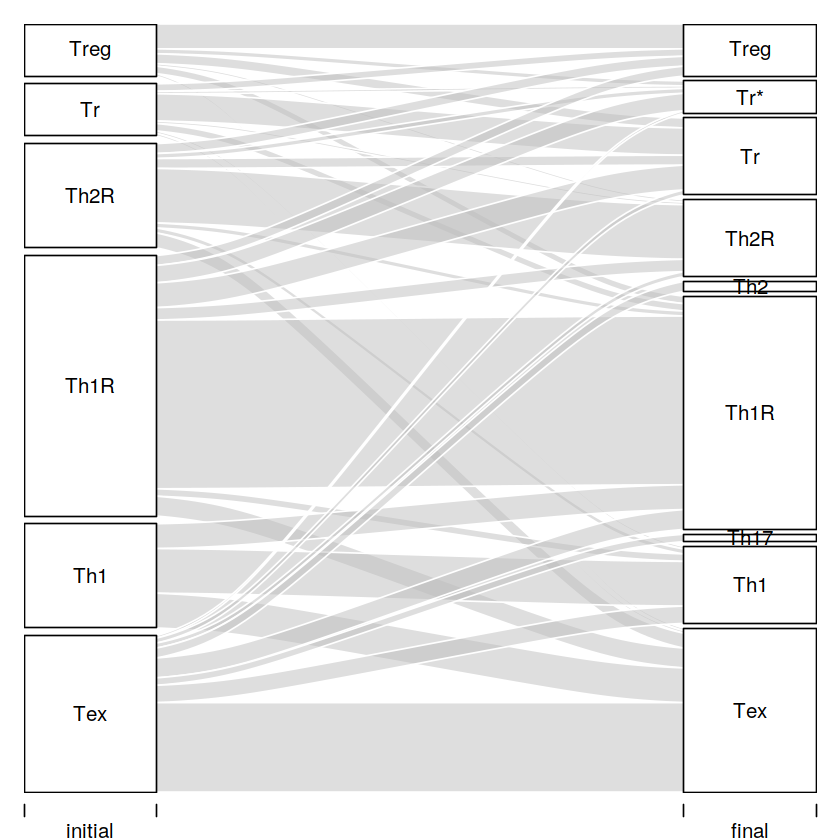

[1] "covtgfb"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


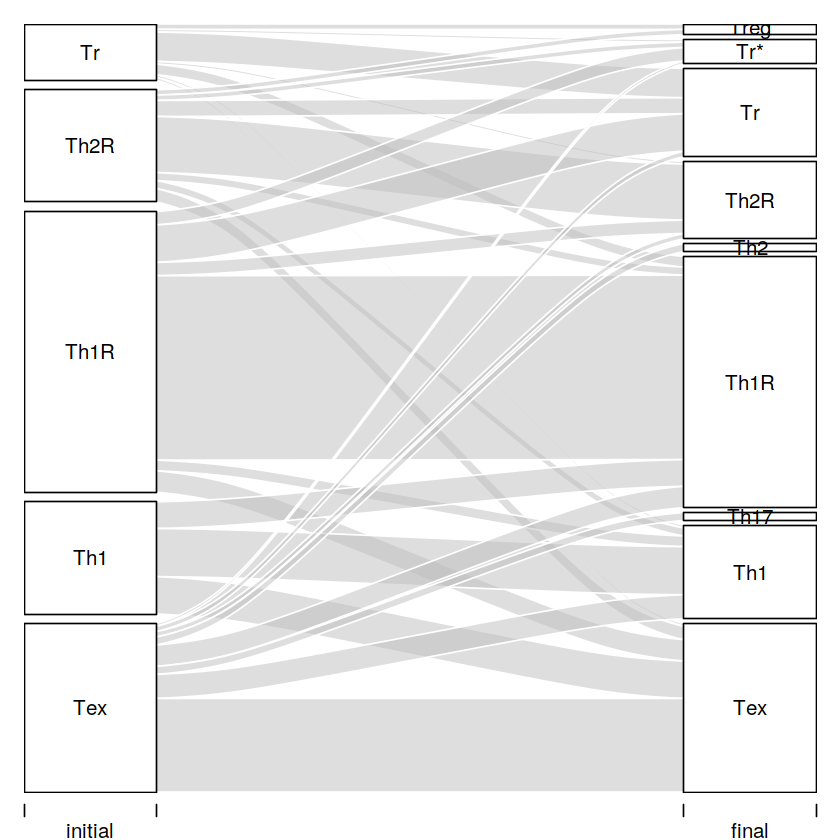

[1] "covil10"


`summarise()` has grouped output by 'initial'. You can override using the `.groups` argument.


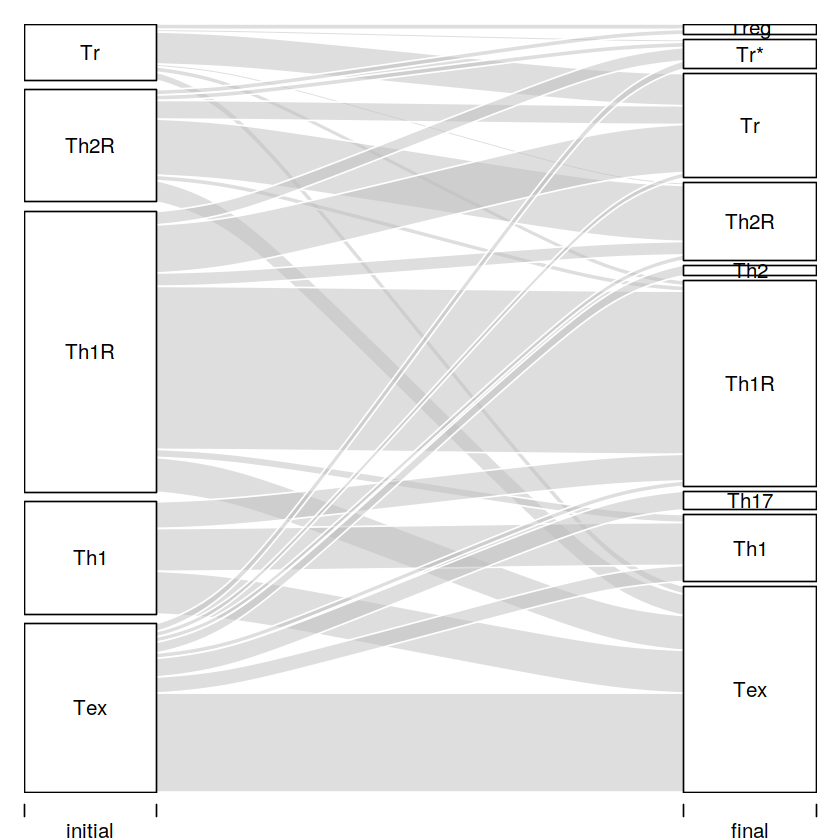

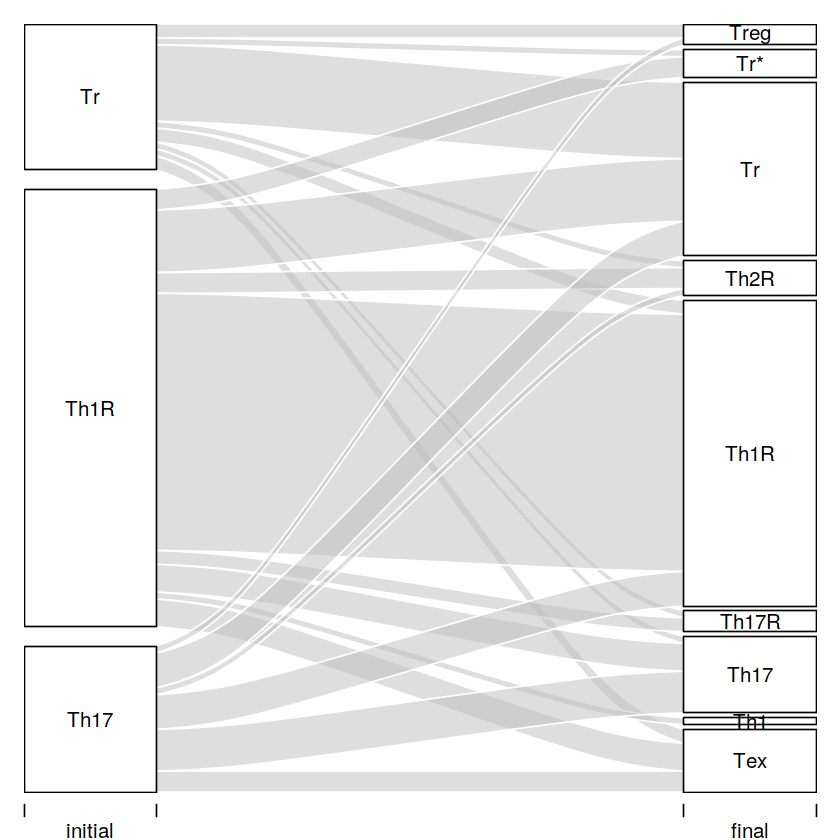

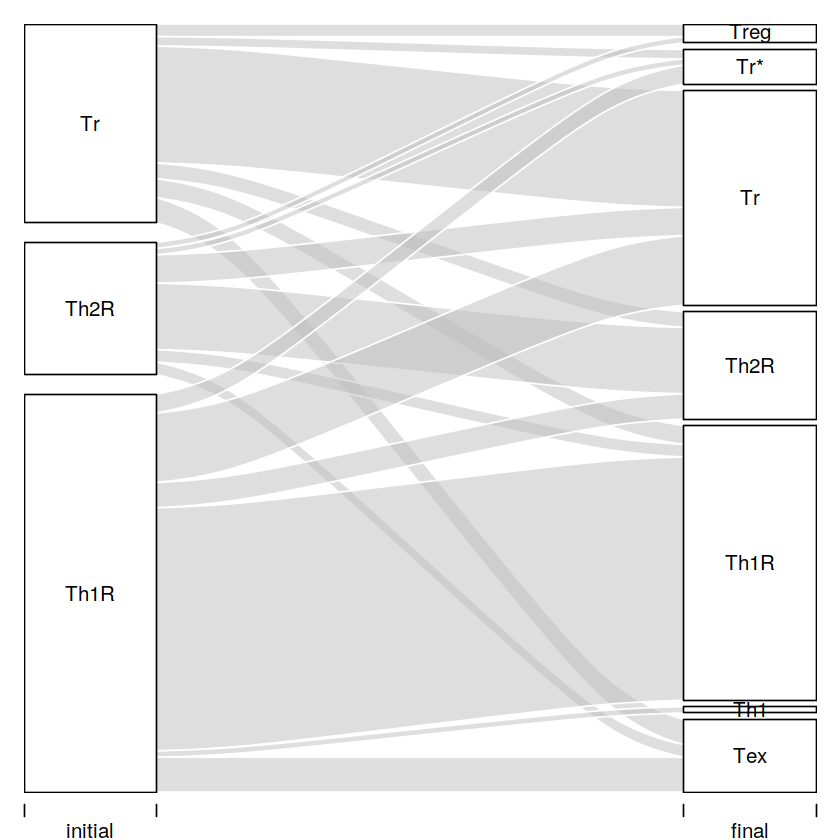

In [11]:
for (env in env.cov) {
    print(env)
    file.name <- NULL
    #file.name <- paste(c("images/thsocs_mut_alluvial_",env,".pdf"), collapse='')
    title <- paste(c("Transitions between cell types in ",env, "\n with perturbations of time infty"), collapse='')
    plot.cfm.alluvial(mut.cov[[env]], file.name, title)
}

### Transitions by node

[1] "covmild"
[1] "covmod"


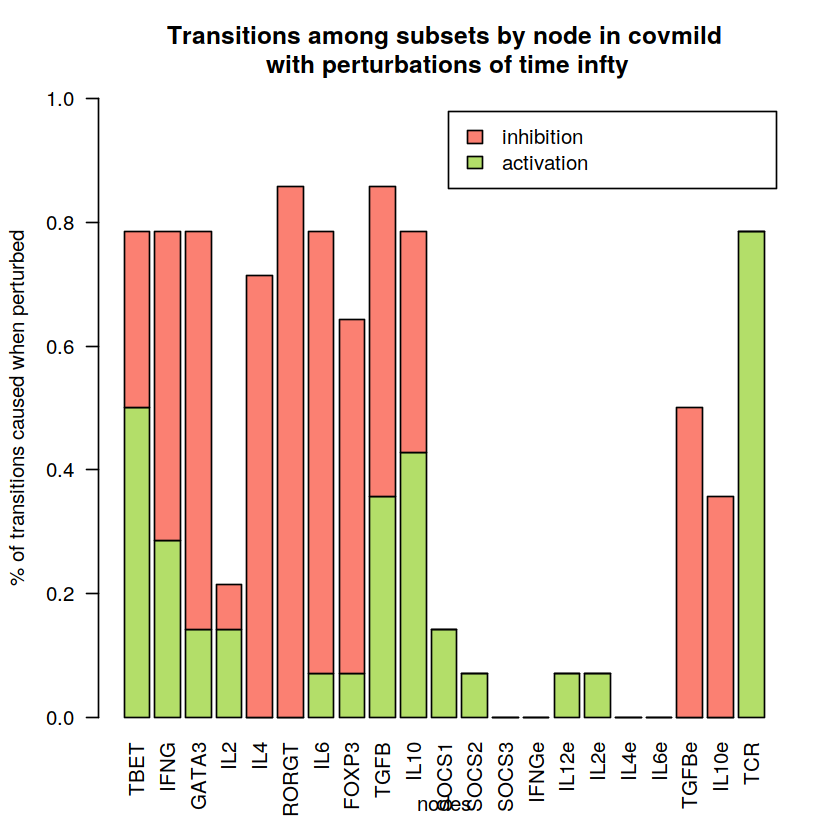

[1] "covsev"


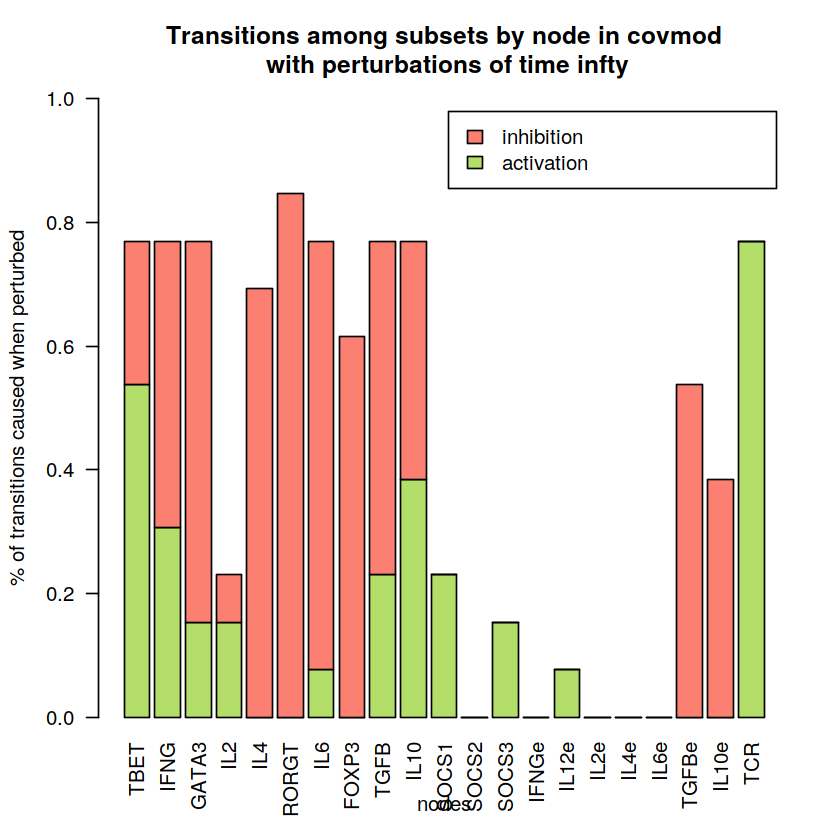

[1] "covtgfb"


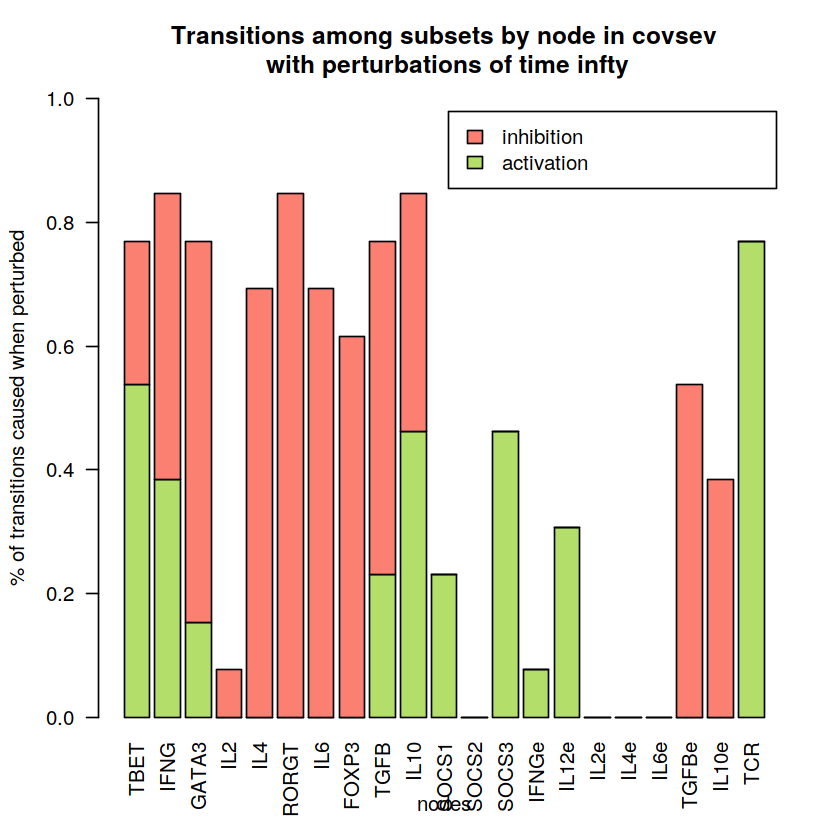

[1] "covil10"


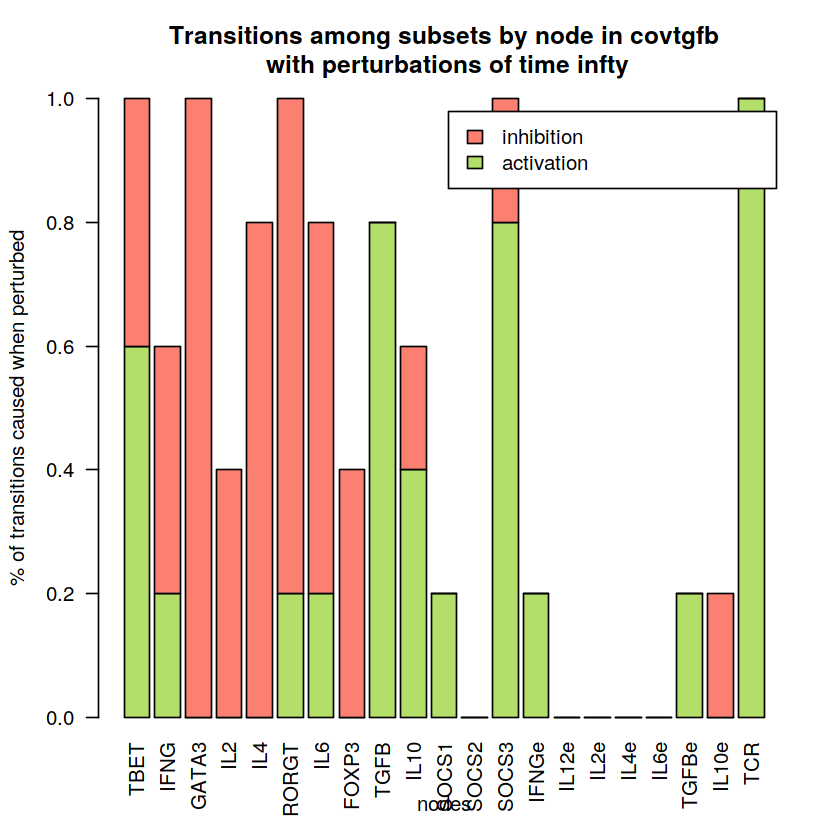

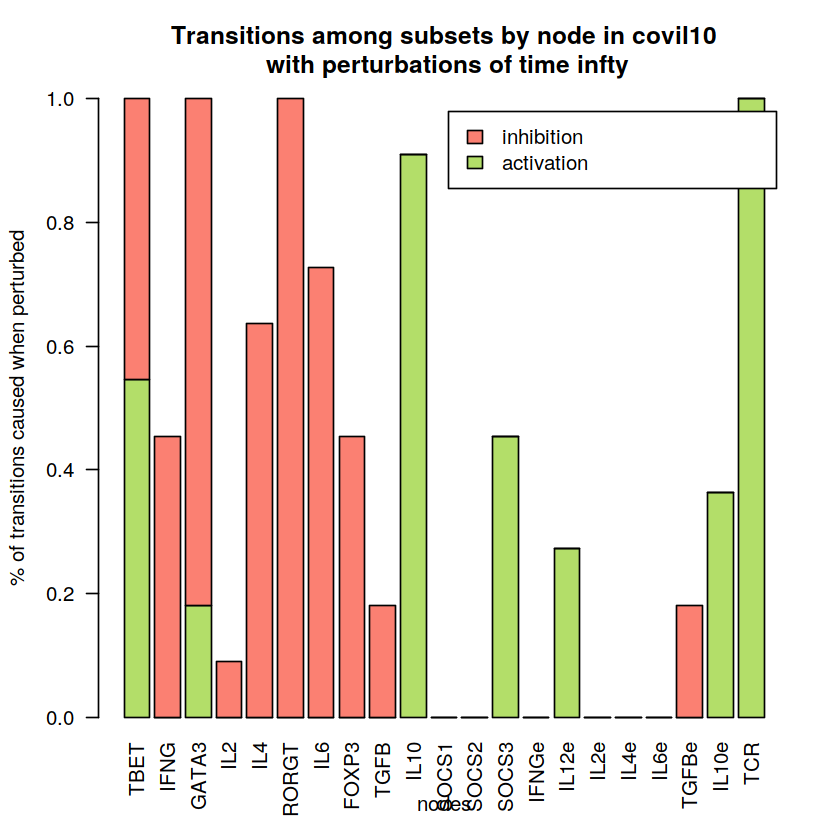

In [12]:
for (env in env.cov) {
    print(env)
    file.name <- NULL
    #file.name <- paste(c("images/thsocs_mut_trannode_",env,".pdf"), collapse='')
    title <- paste(c("Transitions among subsets by node in ",env, "\n with perturbations of time infty"), collapse='')
    plot.node.transitions(mut.cov[[env]], file.name, title)
}

## All mutants

[1] "covmild"
[1] "covmod"


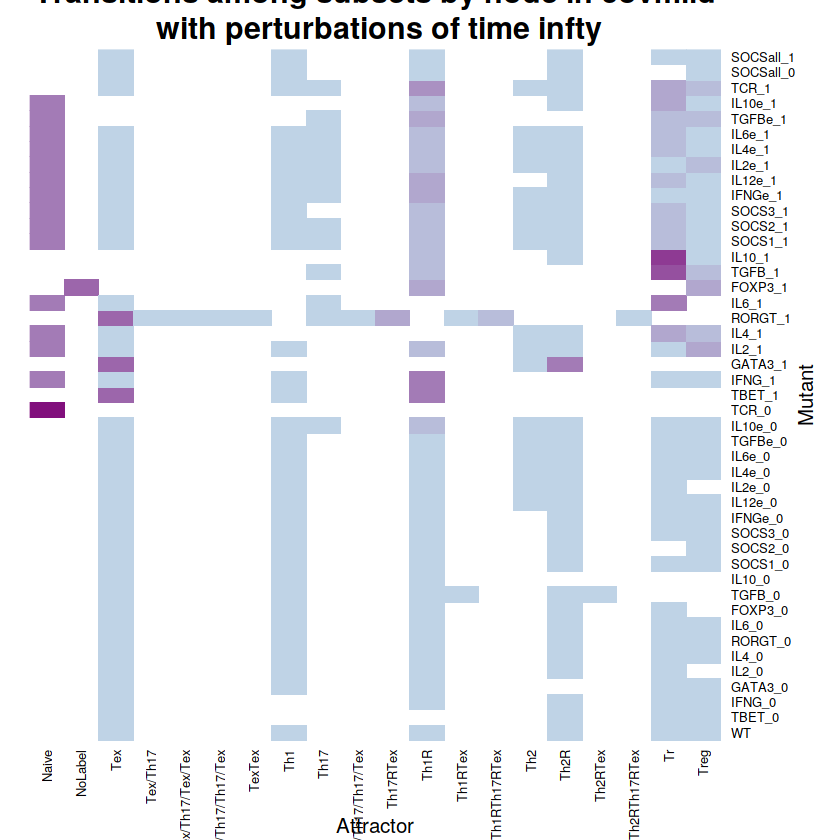

[1] "covsev"


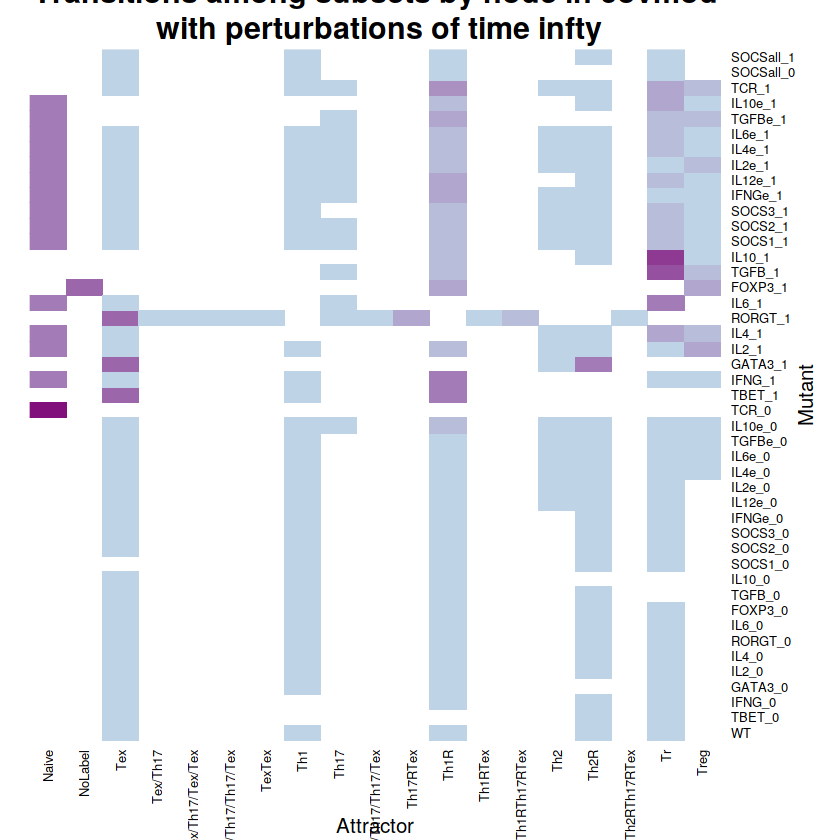

[1] "covtgfb"


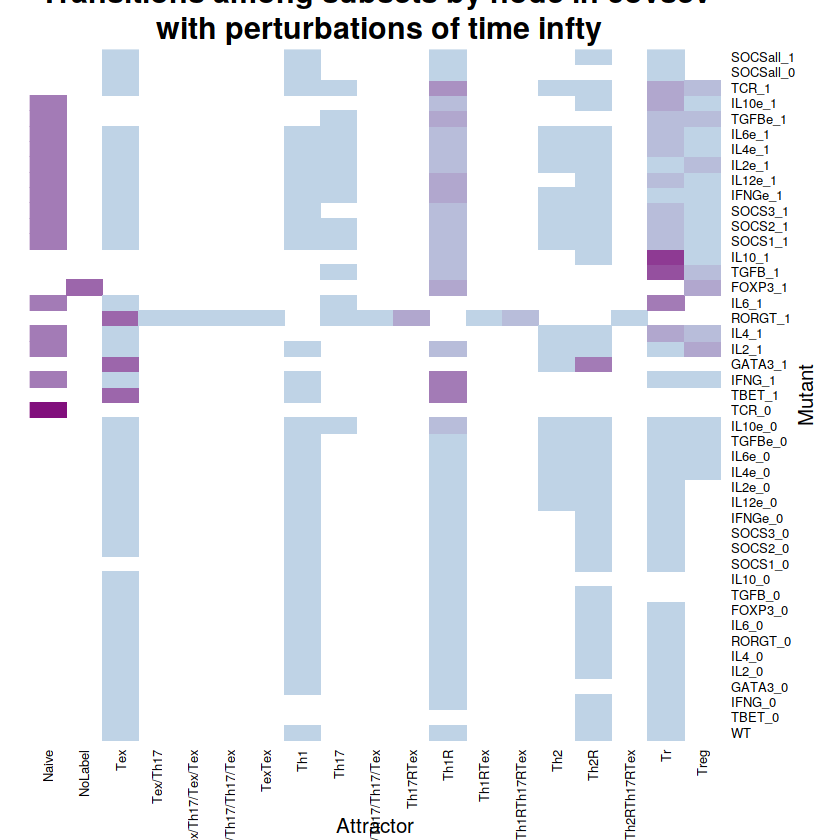

[1] "covil10"


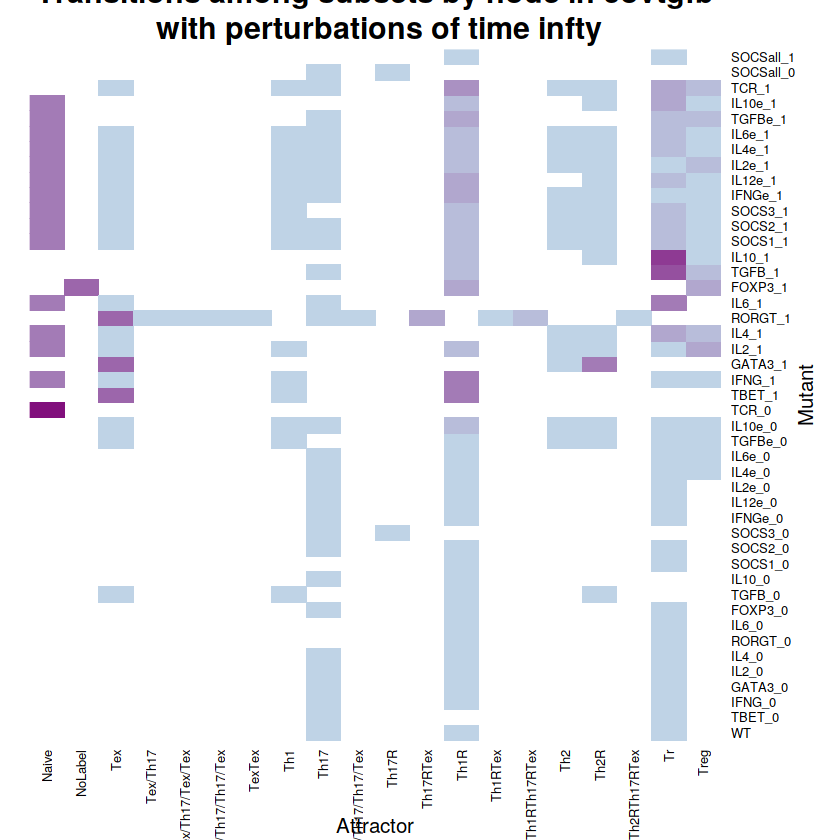

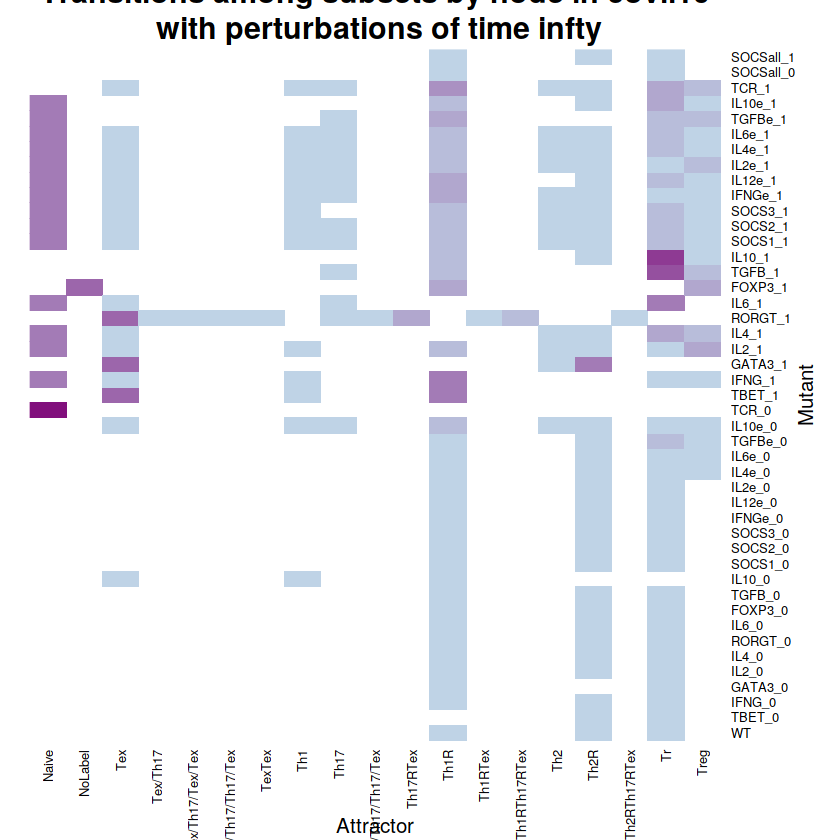

In [13]:
for (env in env.cov) {
    print(env)
    # create table
    file.name <- paste(c("results/thsocs_mut_",env,".csv"), collapse='')
    mut <- f.mut.table(net.cov[[env]], labels, file.name)
    # now plot
    file.name <- NULL
    #file.name <- paste(c("images/thsocs_mut_",env,".pdf"), collapse='')    
    title <- paste(c("Transitions among subsets by node in ",env, "\n with perturbations of time infty"), collapse='')
    f.mut.plot(mut, file.name, title, normalize=F)
}

Done